# Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier,HistGradientBoostingRegressor
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_classif,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (Lasso, 
                                 LassoCV, 
                                 LogisticRegression,
                                 Ridge,
                                 LinearRegression
)

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVC

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 59, "display.max_columns", None
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
celtics = pd.read_excel('nba.xlsx')
celtics = celtics.set_axis(celtics.iloc[0], axis=1).drop(index=0)

not_numbers = ['Date','Opponent','Home_Away','In Season Tournament','Win','Opp_Win_Last_Game']
bool_columns = ['In_Season_Tournament','Opp_Win_Last_Game','Win']

for col in celtics.columns:
    if col not in not_numbers:
        celtics[col] = pd.to_numeric(celtics[col])
    if col in bool_columns:
        celtics[col] = celtics[col].astype(bool)
    
celtics.head(5)

,Date,Opponent,Home_Away,In_Season_Tournament,Celtics_Win_Pct,Celtics_Home_Win_Pct,Celtics_Away_Win_Pct,Celtics_Win_Pct_Last_5_Games,Celtics_Win_Pct_Last_10_Games,Celtics_Avg_Points_Per_Game,Celtics_Avg_Points_Last_5_Games,Celtics_Avg_Points_Last_10_Games,Celtics_Avg_Off_Rating,Celtics_Avg_Off_Rating_Last_10_Games,Celtics_Avg_Def_Rating,Celtics_Avg_Def_Rating_Last_10_Games,Celtics_Avg_FG_Last_10_Games,Celtics_Avg_FG_Pct_Last_10_Games,Celtics_Avg_3P_Last_10_Games,Celtics_Avg_3P_Pct_Last_10_Games,Celtics_Avg_FT_Last_10_Games,Celtics_Avg_FT_Pct_Last_10_Games,Celtics_Rank_In_Conference,Celtics_Rank_In_Division,Celtics_Strength_Of_Key_Players_Missing,Opp_Win_Pct,Opp_Points_Last_Game,Opp_Win_Last_Game,Opp_FG_Last_Game,Opp_FG_Pct_Last_Game,Opp_3P_Last_Game,Opp_3P_Pct_Last_Game,Opp_FT_Last_Game,Opp_FT_Pct_Last_Game,Opp_Off_Rating_Last_Game,Opp_Def_Rating_Last_Game,Opp_Rank_In_Conference,Opp_Rank_In_Division,Opp_Strength_Of_Key_Players_Missing,Win,Celtics_Points,Opp_Points,Diff_Points,Total_Points,Over_Under,Celtics_Spread_Diff,Celtics_Spread_Payout,Opp_Spread_Diff,Opp_Spread_Payout
1,2023-10-25 00:00:00,New York Knicks,Away,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,108,104,4,212,223.0,-3.5,-112,3.5,-108
2,2023-10-27 00:00:00,Miami Heat,Home,False,1.0,NaN,1.0,NaN,NaN,108.000000,NaN,NaN,114.400000,NaN,110.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,1.000000,103.0,True,37.0,0.402,8.0,0.364,21.0,0.808,110.0,108.9,5.0,2.0,2,True,119,111,8,230,217.5,-8.5,-110,8.5,-110
3,2023-10-30 00:00:00,Washington Wizards,Away,False,1.0,1.0,1.0,NaN,NaN,113.500000,NaN,NaN,117.100000,NaN,110.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.500000,113.0,True,40.0,0.430,16.0,0.348,17.0,0.773,111.6,104.7,8.0,3.0,1,True,126,107,19,233,231.5,-10.5,-115,10.5,-105
4,2023-11-01 00:00:00,Indiana Pacers,Home,False,1.0,1.0,1.0,NaN,NaN,117.666667,NaN,NaN,119.333333,NaN,108.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.666667,105.0,False,36.0,0.409,12.0,0.261,21.0,0.840,100.0,103.5,2.0,1.0,4,True,155,104,51,259,233.5,-11.5,-110,11.5,-110
5,2023-11-04 00:00:00,Brooklyn Nets,Away,False,1.0,1.0,1.0,NaN,NaN,127.000000,NaN,NaN,126.575000,NaN,106.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2,0.600000,109.0,True,44.0,0.458,18.0,0.400,3.0,0.600,100.0,115.5,4.0,3.0,5,True,124,114,10,238,227.5,-9.5,-110,9.5,-110


# Trying Some Initial R2 Testing

## Best Individual Column

In [3]:
after_variables = ['Win','Celtics_Points','Opp_Points','Diff_Points','Total_Points']
bad_variables = ['Date','Opponent']
betting_variables = ['Over_Under','Celtics_Spread_Diff','Celtics_Spread_Payout','Opp_Spread_Diff','Opp_Spread_Payout']

cant_use = after_variables + bad_variables + betting_variables

rsquared_values1 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values1[col] = results.rsquared

In [4]:
max(rsquared_values1, key=rsquared_values1.get)

'Opp_Rank_In_Conference'

In [5]:
colmn = max(rsquared_values1, key=rsquared_values1.get)
formula = f'Diff_Points ~ Q("{colmn}")'
print(f'R^2 for {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

R^2 for Opp_Rank_In_Conference: 0.09625387733213664


In [6]:
# rsquared_values

## Best Column with Opp_Rank_In_Conference

In [7]:
cant_use.append(max(rsquared_values1, key=rsquared_values1.get))

rsquared_values2 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Opp_Rank_In_Conference * Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values2[col] = results.rsquared

In [8]:
max(rsquared_values2, key=rsquared_values2.get)

'Celtics_Win_Pct'

In [9]:
colmn = max(rsquared_values2, key=rsquared_values2.get)
formula = f'Diff_Points ~ Opp_Rank_In_Conference * Q("{colmn}")'
print(f'Opp_Rank_In_Conference * {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

Opp_Rank_In_Conference * Celtics_Win_Pct: 0.18076433506511635


In [10]:
# rsquared_values

## Best Column with previous two

In [11]:
cant_use.append(max(rsquared_values2, key=rsquared_values2.get))

rsquared_values3 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Celtics_Win_Pct * Opp_Rank_In_Conference * Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values3[col] = results.rsquared

In [12]:
max(rsquared_values3, key=rsquared_values3.get)

'Celtics_Avg_FG_Pct_Last_10_Games'

In [13]:
colmn = max(rsquared_values3, key=rsquared_values3.get)
formula = f'Diff_Points ~ Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * Q("{col}")'
print(f'Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * Celtics_Avg_FG_Pct_Last_10_Games: 0.20498220724352234


In [14]:
# rsquared_values

In [15]:
celtics['test_var'] = celtics['Celtics_Avg_FT_Pct_Last_10_Games'] * celtics['Opp_Rank_In_Conference'] * celtics['Celtics_Avg_FG_Pct_Last_10_Games']

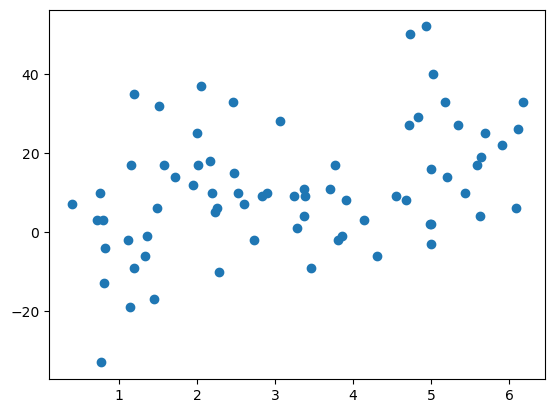

In [16]:
plt.scatter(x=celtics['test_var'],y=celtics['Diff_Points'])

In [17]:
celtics = celtics.drop(columns = 'test_var')

# Machine Learning

In [18]:
after_variables = ['Win','Celtics_Points','Opp_Points','Diff_Points','Total_Points']
bad_variables = ['Date','Opponent']
betting_variables = ['Over_Under','Celtics_Spread_Diff','Celtics_Spread_Payout','Opp_Spread_Diff','Opp_Spread_Payout']

cant_use = after_variables + bad_variables + betting_variables

celtics.head(5)

,Date,Opponent,Home_Away,In_Season_Tournament,Celtics_Win_Pct,Celtics_Home_Win_Pct,Celtics_Away_Win_Pct,Celtics_Win_Pct_Last_5_Games,Celtics_Win_Pct_Last_10_Games,Celtics_Avg_Points_Per_Game,Celtics_Avg_Points_Last_5_Games,Celtics_Avg_Points_Last_10_Games,Celtics_Avg_Off_Rating,Celtics_Avg_Off_Rating_Last_10_Games,Celtics_Avg_Def_Rating,Celtics_Avg_Def_Rating_Last_10_Games,Celtics_Avg_FG_Last_10_Games,Celtics_Avg_FG_Pct_Last_10_Games,Celtics_Avg_3P_Last_10_Games,Celtics_Avg_3P_Pct_Last_10_Games,Celtics_Avg_FT_Last_10_Games,Celtics_Avg_FT_Pct_Last_10_Games,Celtics_Rank_In_Conference,Celtics_Rank_In_Division,Celtics_Strength_Of_Key_Players_Missing,Opp_Win_Pct,Opp_Points_Last_Game,Opp_Win_Last_Game,Opp_FG_Last_Game,Opp_FG_Pct_Last_Game,Opp_3P_Last_Game,Opp_3P_Pct_Last_Game,Opp_FT_Last_Game,Opp_FT_Pct_Last_Game,Opp_Off_Rating_Last_Game,Opp_Def_Rating_Last_Game,Opp_Rank_In_Conference,Opp_Rank_In_Division,Opp_Strength_Of_Key_Players_Missing,Win,Celtics_Points,Opp_Points,Diff_Points,Total_Points,Over_Under,Celtics_Spread_Diff,Celtics_Spread_Payout,Opp_Spread_Diff,Opp_Spread_Payout
1,2023-10-25 00:00:00,New York Knicks,Away,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,108,104,4,212,223.0,-3.5,-112,3.5,-108
2,2023-10-27 00:00:00,Miami Heat,Home,False,1.0,NaN,1.0,NaN,NaN,108.000000,NaN,NaN,114.400000,NaN,110.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,1.000000,103.0,True,37.0,0.402,8.0,0.364,21.0,0.808,110.0,108.9,5.0,2.0,2,True,119,111,8,230,217.5,-8.5,-110,8.5,-110
3,2023-10-30 00:00:00,Washington Wizards,Away,False,1.0,1.0,1.0,NaN,NaN,113.500000,NaN,NaN,117.100000,NaN,110.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.500000,113.0,True,40.0,0.430,16.0,0.348,17.0,0.773,111.6,104.7,8.0,3.0,1,True,126,107,19,233,231.5,-10.5,-115,10.5,-105
4,2023-11-01 00:00:00,Indiana Pacers,Home,False,1.0,1.0,1.0,NaN,NaN,117.666667,NaN,NaN,119.333333,NaN,108.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.666667,105.0,False,36.0,0.409,12.0,0.261,21.0,0.840,100.0,103.5,2.0,1.0,4,True,155,104,51,259,233.5,-11.5,-110,11.5,-110
5,2023-11-04 00:00:00,Brooklyn Nets,Away,False,1.0,1.0,1.0,NaN,NaN,127.000000,NaN,NaN,126.575000,NaN,106.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2,0.600000,109.0,True,44.0,0.458,18.0,0.400,3.0,0.600,100.0,115.5,4.0,3.0,5,True,124,114,10,238,227.5,-9.5,-110,9.5,-110


## Custom Scoring

In [33]:
def custom_easy_score(y, y_pred):
    return min(abs(y - y_pred).mean())

easy_scorer = make_scorer(custom_easy_score, greater_is_better=False)

In [55]:
def custom_profit_score(y, y_pred, celtics_line, celtics_payout, opp_payout, bet=None):
    if bet is None:
        bet = np.ones(len(y))

    if type(bet) in [int, float]:    
        bet = np.ones(len(y)) * bet
    
    bet_on_celtics = y_pred > (celtics_line * -1)
    celtics_win = y > (celtics_line * -1)
    opponent_win = y < (celtics_line * -1)

    payout = ((bet_on_celtics == celtics_win) * (((100/(celtics_payout*-1))*bet*(bet_on_celtics))+((100/(opp_payout*-1))*bet*(1-bet_on_celtics)))) + ((bet_on_celtics == celtics_win) * bet)

    return(sum(payout) - sum(bet))

In [56]:
y_fake = np.array([10,4,10,4])
y_pred_fake = np.array([8,8,2,2])
celtics_line_fake = np.array([-6.5,-6.5,-6.5,-6.5])
celtics_payout_fake = np.array([-110,-110,-110,-110])
opp_payout_fake = np.array([-110,-110,-110,-110])
bet_fake = 100

custom_profit_score(y = y_fake,
                    y_pred = y_pred_fake,
                    celtics_line = celtics_line_fake,
                    celtics_payout = celtics_payout_fake,
                    opp_payout = opp_payout_fake,
                    bet = bet_fake)

-18.181818181818187

In [57]:
profit_scorer = make_scorer(custom_profit_score)

## Splitting

In [22]:
# the month of april is not a good representation of the season
celtics = celtics.drop(index=celtics.tail(8).index)

In [23]:
# train on the whole season up to march
X_train = celtics.drop(columns = [col for col in after_variables])
X_train = X_train.drop(index=celtics.tail(16).index)
# X_train
# 58 rows

In [24]:
# predict the month of march
X_test = celtics.drop(columns = [col for col in after_variables])
X_test = X_test.tail(16)
# X_test
# 16 rows

In [25]:
y_train = celtics['Diff_Points']
y_train = y_train.drop(index=celtics.tail(16).index)
# y_train

In [26]:
y_test = celtics['Diff_Points']
y_test = y_test.tail(16)
# y_test

## Custom CV Fold

In [27]:
cv_custom = [
    (list(range(0,10,1)),list(range(10,15,1))),
    (list(range(0,15,1)),list(range(15,20,1))),
    (list(range(0,20,1)),list(range(20,25,1))),
    (list(range(5,25,1)),list(range(25,30,1))),
    (list(range(10,30,1)),list(range(30,35,1))),
    (list(range(15,35,1)),list(range(35,40,1))),
    (list(range(20,40,1)),list(range(40,45,1))),
    (list(range(25,45,1)),list(range(45,50,1))),
    (list(range(30,50,1)),list(range(50,55,1))),
    (list(range(33,53,1)),list(range(53,58,1))),
            ]
# cv_custom
# len(cv_custom)
# 10 folds

## Preprocessing

In [28]:
# celtics.info()

In [29]:
# numerical and categorical pipelines
numer_pipe = Pipeline(
    [
        ("imputer",SimpleImputer(strategy='median')),
        ("scaler",StandardScaler())
    ])

cat_pipe = Pipeline(
    [
        ("encoder",OneHotEncoder())
    ])

# numerical and categorical variables to use
numer_variables = celtics.select_dtypes(include='number').columns
numer_variables = [var for var in numer_variables if var not in cant_use]

cat_variables = ['In_Season_Tournament','Opp_Win_Last_Game']

# preprocessing pipeline
preproc_pipe = ColumnTransformer(
    [
        ("numer",numer_pipe,numer_variables),
        ("cat",cat_pipe,cat_variables)
    ],
        remainder='drop')

# preprocessing dataframe
preproc_df = df_after_transform(preproc_pipe,X_train)
print(f"There are {preproc_df.shape[1]} columns in the preprocessed dataframe")
# preproc_df.describe().T.round(2)
# preproc_df

There are 38 columns in the preprocessed dataframe


## Testing Models

In [30]:
pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select','passthrough'),
        ('clf',Lasso())
    ])
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Celtics_Win_Pct',
                                                   'Celtics_Home_Win_Pct',
                                                   'Celtics_Away_Win_Pct',
                                                   'Celtics_Win_Pct_Last_5_Games',
                                                   'Celtics_Win_Pct_Last_10_Games',
                                                   'Celtics_Avg_Points_Per_Game',
                                                   'Celtics_Avg_Points_Last_5_Games'...
                                                   'Celtics_Strength_Of_Key_Players_Missing',
                                                   'Opp_Win_Pct',
                                                   'Opp_Points_Last_Game',
                                                   'Opp_FG_Last_Game',
                                                   'Opp_FG_Pct_Last_Game',
                                                   'Opp_3P_Last_Game',
                                                   'Opp_3P_Pct_Last_Game',
                                                   'Opp_FT_Last_Game',
                                                   'Opp_FT_Pct_Last_Game',
                                                   'Opp_Off_Rating_Last_Game', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['In_Season_Tournament',
                                                   'Opp_Win_Last_Game'])])),
                ('feature_select', 'passthrough'), ('clf', Lasso())])

In [59]:
grid_search = GridSearchCV(
    estimator=pipe,
    scoring=profit_scorer,
    cv=cv_custom,
    param_grid={'clf__alpha': [a for a in np.linspace(0.1,1,5)]})
pd.DataFrame(grid_search.fit(X_train,y_train).cv_results_)

# results = grid_search.fit(X_train,y_train)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019957,0.002719,0.009425,0.001345,0.1,{'clf__alpha': 0.1},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.021680,0.001714,0.009695,0.001098,0.325,{'clf__alpha': 0.325},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0.021451,0.001891,0.009349,0.001442,0.55,{'clf__alpha': 0.55},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0.021245,0.000932,0.009833,0.000774,0.775,{'clf__alpha': 0.775},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0.020267,0.001905,0.009830,0.000730,1.0,{'clf__alpha': 1.0},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [32]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',